# **Actividad I**
## *Antonio Cabrera, Álvaro Salís y Alejandro Gómez*

### Imagen 1 – CLAHE manual

CLAHE divide la imagen en zonas de 32x32 píxeles, para cada zona se calcula un histograma de intensidades y se plica ecualización local estableciendo un clip-limit(limita la apmplitud) que evita que se amplifique el ruido. Luego interpola los resultados de cada zona para que no se noten cortes o discontinuidades en la imagen.

Nuevo_valor = (acumulado(valor) / total_pixeles) × 255

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_14964\3718518472.py:23: RuntimeWarning: invalid value encountered in divide
  cdf_normalizado = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
C:\Users\Alejandro\AppData\Local\Temp\ipykernel_14964\3718518472.py:28: RuntimeWarning: invalid value encountered in cast
  return np.clip(resultado, 0, 255).astype(np.uint8)


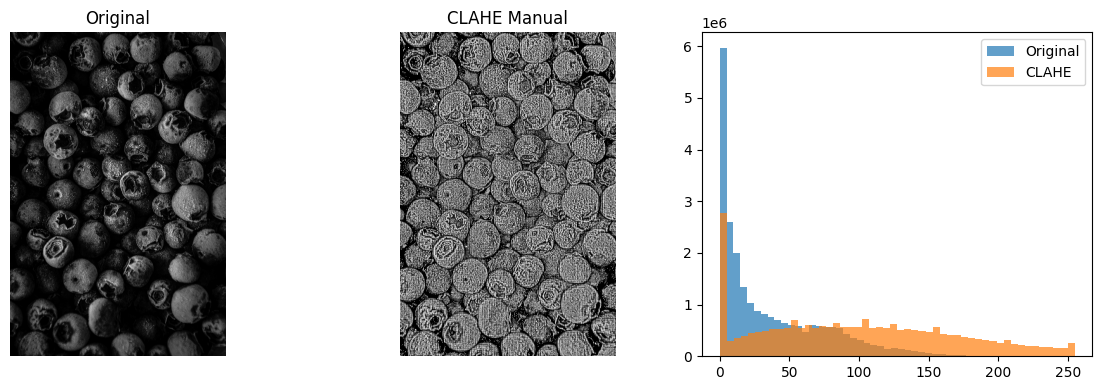

False

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def clahe_manual(imagen, tamano_tile=64, limite_recorte=2.0):
    h, w = imagen.shape
    resultado = np.zeros_like(imagen, dtype=np.float32)
    
    for y in range(0, h, tamano_tile):
        for x in range(0, w, tamano_tile):
            tile = imagen[y:y+tamano_tile, x:x+tamano_tile]
            
            hist = np.zeros(256)
            for valor in tile.flatten():
                hist[valor] += 1
            
            limite = int(limite_recorte * tile.size / 256)
            for i in range(256):
                if hist[i] > limite:
                    hist[i] = limite
            
            cdf = hist.cumsum()
            cdf_normalizado = (cdf - cdf.min()) * 255 / (cdf.max() - cdf.min())
            
            tile_mejorado = cdf_normalizado[tile]
            resultado[y:y+tamano_tile, x:x+tamano_tile] = tile_mejorado
    
    return np.clip(resultado, 0, 255).astype(np.uint8)

imagen_original = cv2.imread('images/1.jpg')
imagen_gris = cv2.cvtColor(imagen_original, cv2.COLOR_BGR2GRAY)

imagen_clahe = clahe_manual(imagen_gris, tamano_tile=32, limite_recorte=2.0)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(imagen_gris, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(imagen_clahe, cmap='gray')
plt.title('CLAHE Manual')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.hist(imagen_gris.ravel(), bins=50, alpha=0.7, label='Original')
plt.hist(imagen_clahe.ravel(), bins=50, alpha=0.7, label='CLAHE')
plt.legend()

plt.tight_layout()
plt.show()

cv2.imwrite('out/imagen1_original.jpg', imagen_gris)
cv2.imwrite('out/imagen1_clahe_manual.jpg', imagen_clahe)

En los resultados podemos ver una clara diferenciación de contraste entre las regiones más expuestas y las más oscuras y opacas, se pueden observar los detalles recalcados en la imagen alterada y las formas de cada objeto claramente.

### Imagen 2 - Cambiar saturación

Es identico al metodo aplicado para la imagen uno, solo que esta vez se aplica solo al canal de luminancia "L" en el contexto LAB.
Entonces convertimos el típico RGB a un espacio LAB (l-luminancia a/b componentes cromaticos) y aplicamos el metodo CLAHE solo al canal L, preservando asi el color original y evitando cambios de saturación y tono.

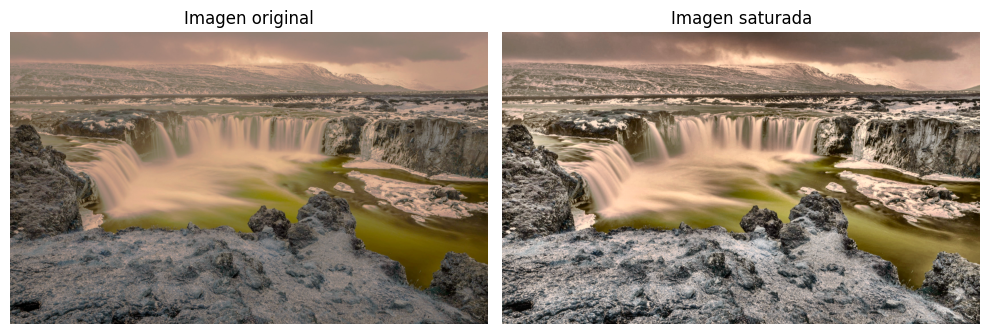

False

In [28]:
img_2 = cv2.imread("./images/2.jpg")
lab = cv2.cvtColor(img_2, cv2.COLOR_BGR2LAB)
lightness, red_green_channel, blue_yellow_channel = cv2.split(lab)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
lightness_contrast = clahe.apply(lightness)

lab_contrast = cv2.merge([lightness_contrast, red_green_channel, blue_yellow_channel])
img_2_contrast = cv2.cvtColor(lab_contrast, cv2.COLOR_LAB2BGR)

fig, axs = plt.subplots(1, 2, figsize=(10, 8))

axs[0].set_title("Imagen original")
axs[1].set_title("Imagen saturada")

axs[0].axis('off')
axs[1].axis('off')

axs[0].imshow(img_2)
axs[1].imshow(img_2_contrast)

fig.tight_layout()

plt.show()

cv2.imwrite("./out/2.jpg", lab_contrast)

Como podemos ver sobretodo en la roca de la imagen, el contraste local se mejora considerablemente y partes de la cascada se ven más diferenciadas. Aunque no hemos conseguido una mejora total tanto la roca como las nubes se ven mejoradas de contraste.

### Imagen 3 - Eliminar ruido

Para cada píxel se examina una región de 5x5 píxeles que vamos a ir desplazando por toda la imagen, se ordenan los valores de intensidad y se elige el valor medio como nuevo valor del píxel central

PSNR = 20 × log10(MAX_I / √MSE)

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('3.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

b, g, r = cv2.split(img_rgb)

b_median = cv2.medianBlur(b, 5)
g_median = cv2.medianBlur(g, 5)
r_median = cv2.medianBlur(r, 5)
img_median = cv2.merge([b_median, g_median, r_median])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_median)
plt.title('Filtro Mediana')
plt.axis('off')

plt.tight_layout()
plt.show()

error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


Consigue limpiar bastante el ruido de la hoja y se puede apreciar un contorno más definido y limpio, aunque no se ha eliminado del todo el ruido. Las transiciones de color entre verde y blanco que se encuentran en el tallo, que son más extremas al ser la zona más fina, se ven con claridad

### Imagen 4 - Eliminar ruido

Dividimos la imagen en bloques de tamaños predefinidos y fijos (8x8) y para cada bloque calculamos el valor medio de todos los píxeles y asignamos el valor a todo el bloque. Esto puede significar en la pérdida de información pero justo para la imagen de la radiografía nos viene muy bien aplicarlo ya que aunque perdamos definición, pretendemos mantener la estructura de la foto lo máximo posible y eliminar casi del todo el ruido.

Filtro por bloques de media

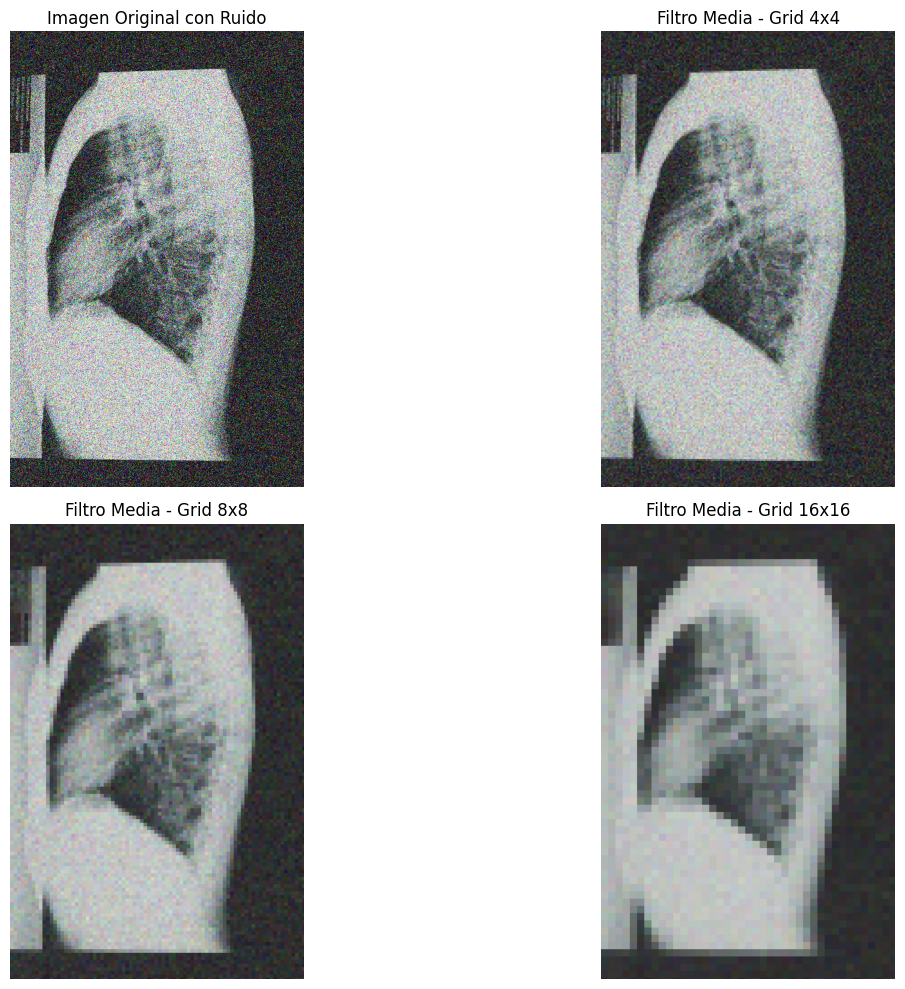

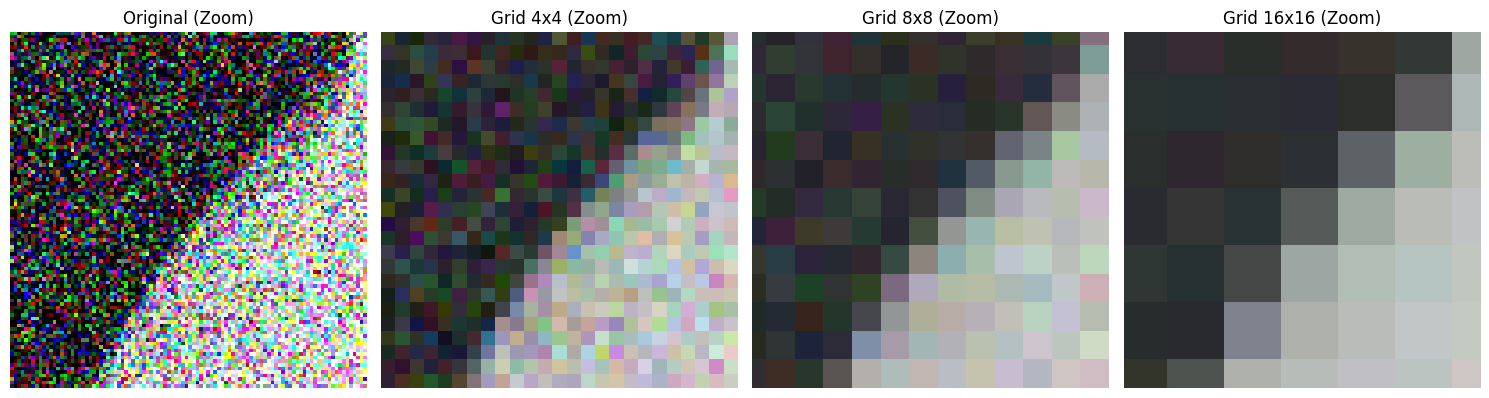

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def filtro_media_por_bloques(imagen, tamaño_grid=8):
    h, w = imagen.shape[:2]
    resultado = imagen.copy()
    
    for y in range(0, h, tamaño_grid):
        for x in range(0, w, tamaño_grid):
            grid = imagen[y:y+tamaño_grid, x:x+tamaño_grid]
            media = np.mean(grid, axis=(0,1))
            resultado[y:y+tamaño_grid, x:x+tamaño_grid] = media
    
    return resultado.astype(np.uint8)

img_ruidosa = cv2.imread('images/4.png')
img_rgb = cv2.cvtColor(img_ruidosa, cv2.COLOR_BGR2RGB)

img_grid4 = filtro_media_por_bloques(img_rgb, tamaño_grid=4)
img_grid8 = filtro_media_por_bloques(img_rgb, tamaño_grid=8)
img_grid16 = filtro_media_por_bloques(img_rgb, tamaño_grid=16)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(img_rgb)
plt.title('Imagen Original con Ruido')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(img_grid4)
plt.title('Filtro Media - Grid 4x4')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(img_grid8)
plt.title('Filtro Media - Grid 8x8')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(img_grid16)
plt.title('Filtro Media - Grid 16x16')
plt.axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))

y1, y2, x1, x2 = 100, 200, 100, 200  

plt.subplot(1, 4, 1)
plt.imshow(img_rgb[y1:y2, x1:x2])
plt.title('Original (Zoom)')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(img_grid4[y1:y2, x1:x2])
plt.title('Grid 4x4 (Zoom)')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(img_grid8[y1:y2, x1:x2])
plt.title('Grid 8x8 (Zoom)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(img_grid16[y1:y2, x1:x2])
plt.title('Grid 16x16 (Zoom)')
plt.axis('off')

plt.tight_layout()
plt.show()

Como podemos ver en la comparación, a mayor el tamaño del bloque menos ruido, pero sacrificamos parte de la estructura del bloque y perdemos definición, justo en las radiografias es realmente útil ya que lo importante es tener una imagen sin interferencias ni manchas sin importar mucho la perdida de definición.

Filtro por bloques de medias no locales

### Imagen 5 - Filtro gausiano

Generamos un kernel gausiano 20x20 píxeles usando la funcion de distribucion normal bidimensional, luego tenemos que normalizar este kernel para poder sumar sus coeficientes y que nos de 1, asi preservamos el brillo de la imagen. Asi conseguimos un suavizado que preserve los bordes de la imagen

Filtro Gaussiano 

$$
G(x,y) = \frac{1}{2\pi\sigma^2} e^{\frac{-x^2+y^2}{2\sigma^2}}
$$

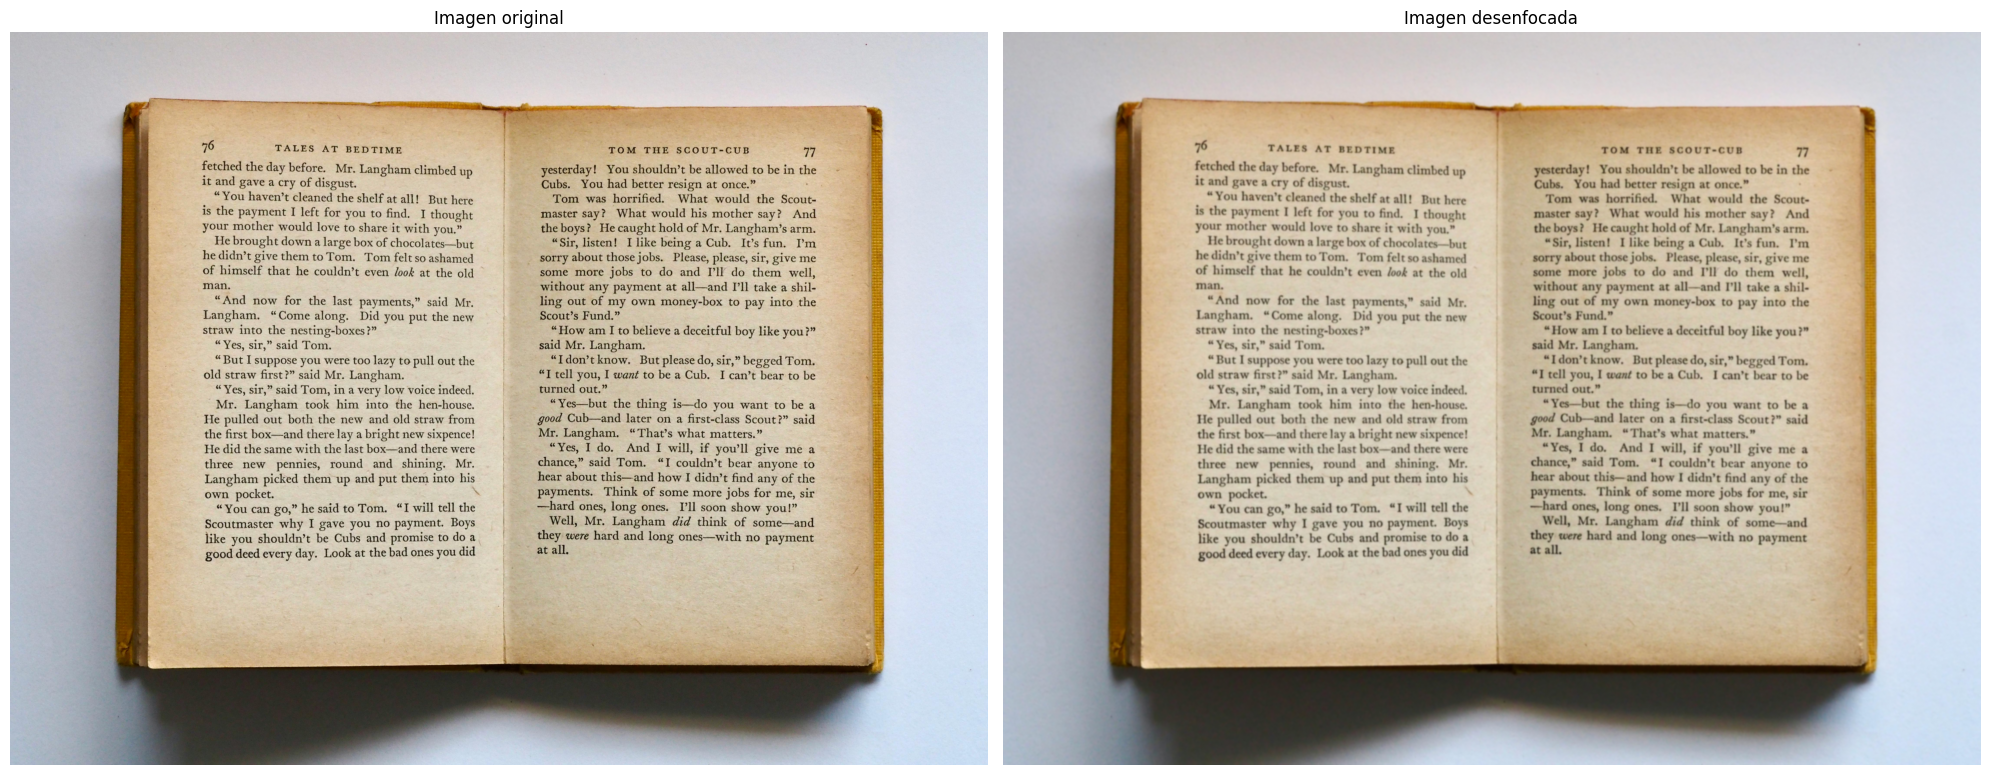

In [31]:
# Crea un kernel gaussiano
def gaussian_kernel(size, sigma):
    x = np.arange(0, size, 1, float)
    x0 = size // 2
    x = x - x0
    kernel_1d = np.exp(-(x ** 2) / (2 * sigma ** 2))
    kernel = np.outer(kernel_1d, kernel_1d)
    kernel = kernel / np.sum(kernel)
    return kernel

# Carga la imagen
img = cv2.imread('images/5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Crea el kernel gaussiano
kernel = gaussian_kernel(20, 3)

# Aplica el kernel a la imagen
img_blur = np.zeros_like(img)
for i in range(3):
    img_blur[:, :, i] = cv2.filter2D(img[:, :, i], -1, kernel)

# Muestra la imagen original y la imagen desenfocada
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Imagen original')
plt.subplot(1, 2, 2)
plt.imshow(img_blur.astype(np.uint8))
plt.axis('off')
plt.title('Imagen desenfocada')
plt.tight_layout()
plt.show()

Como genera transiciones más suaves podemos observar como la letra en la segunda imagen está menos nítida.

### Imagen 6 - Filtro de Kuwahara

Analiza la homogeniedad regional, para cada píxel divide una ventana 5x5 en 4 subregiones que están solapadas. Se calcula la media y varianza de cada subregión y selecciona la media de la region con menos varianza como nuevo valor del pixel, es decir, la más homogénea se convierte en en nuevo píxel.


In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def kuwahara_filter(img, window_size=5):
    h, w = img.shape
    pad = window_size//2
    padded = np.pad(img, pad, mode="edge")
    output = np.zeros_like(img)
    
    #precalculamos offsets para las subregiones
    offset = pad
    
    for i in range(h):
        for j in range(w):

            y_start, y_end = i, i + window_size
            x_start, x_end = j, j + window_size
            
            #4 subregiones
            regions = [
                (y_start, y_start + offset + 1, x_start, x_start + offset + 1),  
                (y_start, y_start + offset + 1, x_start + offset, x_end),        
                (y_start + offset, y_end, x_start, x_start + offset + 1),        
                (y_start + offset, y_end, x_start + offset, x_end)               
            ]
            
            min_variance = float('inf')
            selected_mean = 0
            #media y varianza
            for y1, y2, x1, x2 in regions:
                subregion = padded[y1:y2, x1:x2]
                mean_val = np.mean(subregion)
                variance = np.var(subregion)
                
                if variance < min_variance:
                    min_variance = variance
                    selected_mean = mean_val
            
            output[i, j] = selected_mean
    
    return np.clip(output, 0, 255)


img = cv2.imread('images/6.jpg', cv2.IMREAD_GRAYSCALE)
img_kuwahara = kuwahara_filter(img, window_size=5)

#resultados
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_kuwahara, cmap='gray'); plt.title("Kuwahara Filter"); plt.axis('off')
plt.show()


KeyboardInterrupt: 

Lo que vemos son lineas en los edificios muy bien definidas y reduce un poco el ruido en cada cartel luminoso, haciendo la imagen más llamativa y con más profundidad.

### Imagen 7 - Detección de Bordes

Aplicamos dos kernels de forma separada, para el eje X y el Y que aproximan las derivadas horizontales y verticales de la imagen, luego se calcula la magnitud del gradiente como la raiz cuadrada de la suma de los cuadrados de ambas derivadas, estas derivadas se aproximan mediante convolución de kernels.

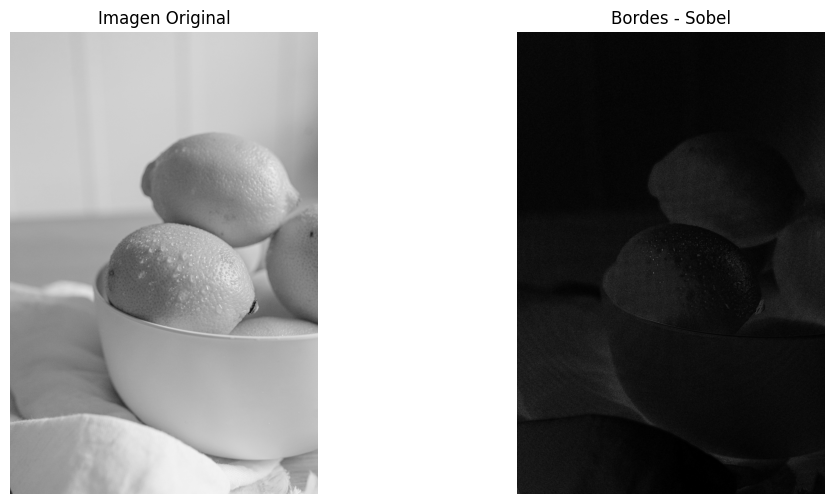

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def sobel_edges(image):
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    magnitude = np.sqrt(grad_x**2 + grad_y**2)

    magnitude = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    return magnitude.astype(np.uint8)

img = cv2.imread('images/7.jpg', cv2.IMREAD_GRAYSCALE)

#bordes
edges = sobel_edges(img)

#resultados
plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title("Imagen Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(edges, cmap='gray'); plt.title("Bordes - Sobel"); plt.axis('off')
plt.show()


Como podemos observar los contornos que están cerca de sombras quedan muy bien delimitados (zona inferior del bol y de los limones) pero en el reflejo de los limones el tono del fondo y del limón no se diferencia tanto y la imagen no recalca ese borde totalmente. Igualmente el filtro detecta tanto los bordes del limón, como del bol y de la toalla sin mucho problema.

### Imagen 8 - Detección de objetos

Aplicamos un umbral global de 120 para crear una máscara binaria que separa objetos del fondo, luego con la máscara hecha se aplica el algoritmo Suzuki-abe para encontrar los contornos en esa máscara binaria, dejando al descubierto los contornos de la máscara.

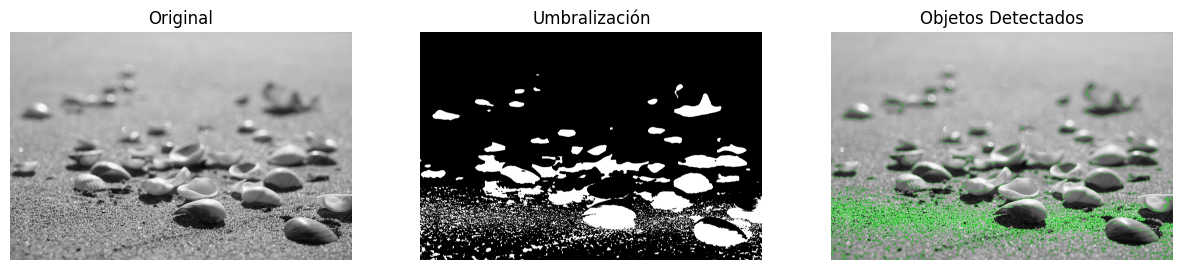

Objetos detectados: 7278


: 

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detectar_objetos(image, thresh_value=128):
    #umbralizacion
    _, binary = cv2.threshold(image, thresh_value, 255, cv2.THRESH_BINARY_INV)

    #contornos
    contornos, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Crear copia en RGB para dibujar
    img_contornos = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_contornos, contornos, -1, (0, 255, 0), 2)

    return img_contornos, binary, contornos


img = cv2.imread('images/8.jpg', cv2.IMREAD_GRAYSCALE)

#detectamos lo objetos
img_contornos, img_binaria, contornos = detectar_objetos(img, thresh_value=120)

#resultados
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_binaria, cmap='gray'); plt.title("Umbralización"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(img_contornos[..., ::-1]); plt.title("Objetos Detectados"); plt.axis('off')
plt.show()

print(f"Objetos detectados: {len(contornos)}")


Hemos calculado los objetos detectados para saber si solo reconocía las conchas o algo más, como los contornos aparecen destacados en verde podemos observar que el algoritmo ha reconocido el relieve del suelo como objetos y por eso no solo aparecen las conchas coloreadas. Todas las conchas aparecen rodeadas y gracias a la foto de la umbralización podemos ver como la máscara binaria detecta los objetos, indicandonos que hay bastante ruido en la parte inferior dela foto.

### Imagen 9 y 10 - Comparacion Métrica de Similitud

Tenemos 2 imagenes que representan la Torre Eiffel desde distintos puntos y queremos que el algoritmo detecte si el objeto es el mismo o no. El MSE (error cuadratico medio) cuantifica la diferencia entre cada pixel, y si el valor es alto indicará que hay dos puntos de vista muy diferentes, el PSNR relaciona el rango dinámico con el error, por lo que un resultado moderado en PSNR puede indicar que se trata de un objeto muy similar, y el SSIM modela la percepción del ojo humano, considerando luminosidad, contraste y la estructura del objeto, asi que se encarga de indicar patrones y similitudes estructurales sin importar la perspectiva.

MSE: 7548.125174468007
PSNR:9.35241267185037
SSIM:0.36782826767655147


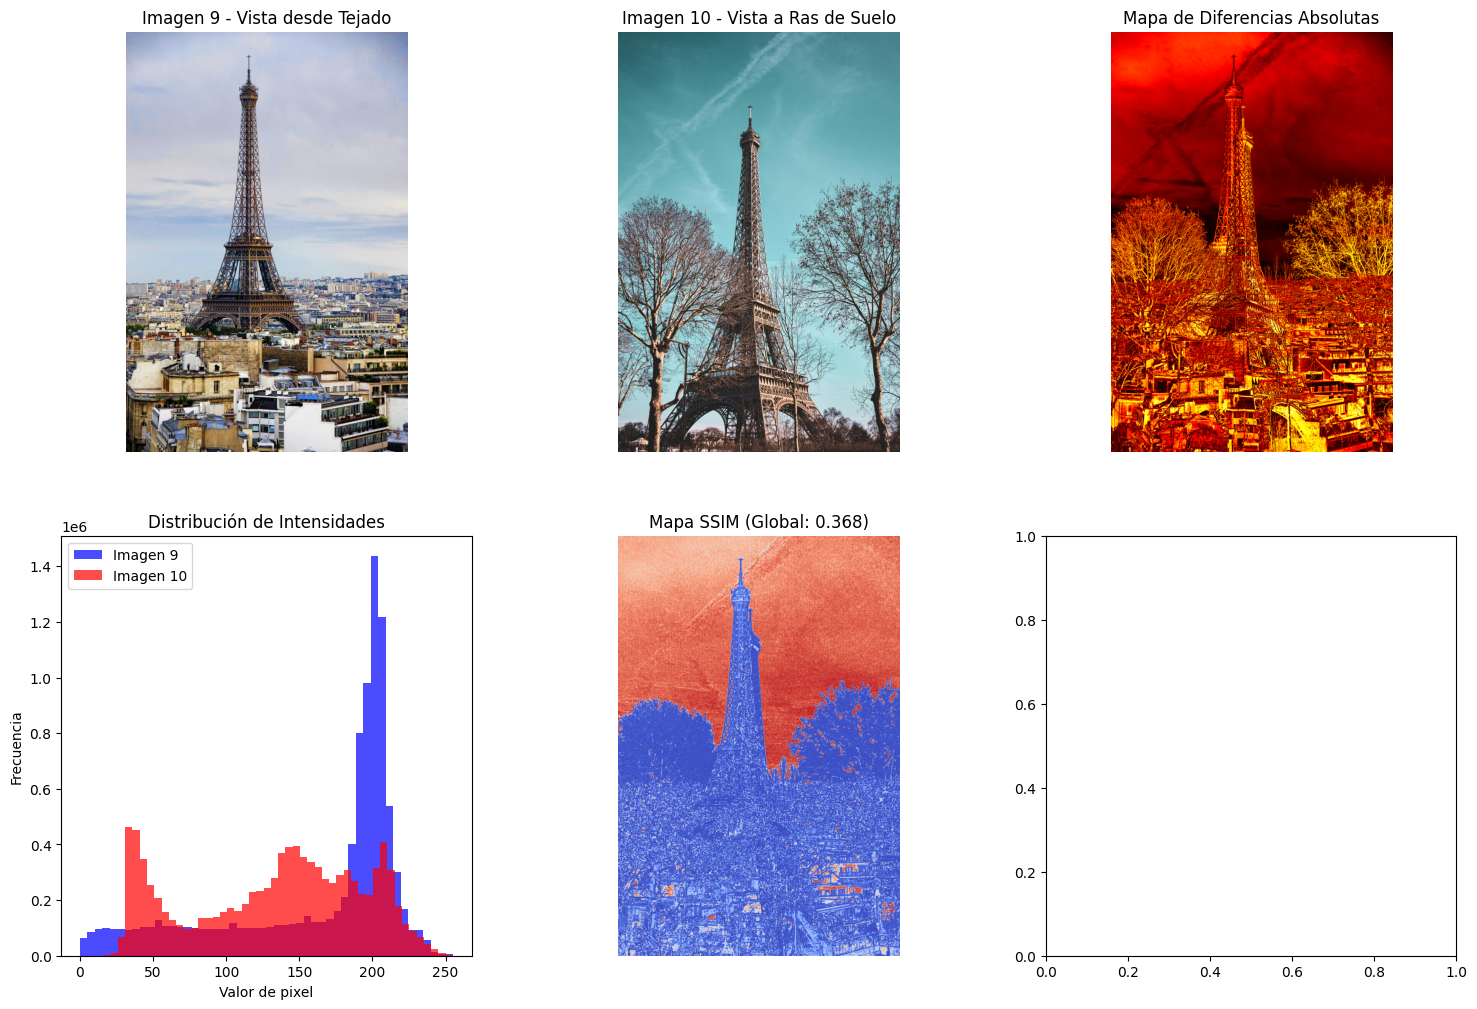

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def mse(img1, img2):

    return np.mean((img1.astype(float) - img2.astype(float)) ** 2)

def psnr(img1, img2):

    mse_val = mse(img1, img2)
    if mse_val == 0:
        return float("inf")
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse_val))

def comparar_imagenes(img_path1, img_path2):
    """
    Compara dos imágenes de la Torre Eiffel desde diferentes perspectivas
    utilizando múltiples métricas de similitud.
    """

    img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2)
    
    #RGB para visualización
    img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    #escala de grises para cálculo de métricas
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    #comprobamos que tengan el mismo tamaño
    gray2 = cv2.resize(gray2, (gray1.shape[1], gray1.shape[0]))
    img2_rgb = cv2.resize(img2_rgb, (img1_rgb.shape[1], img1_rgb.shape[0]))
    

    mse_val = mse(gray1, gray2)
    psnr_val = psnr(gray1, gray2)
    ssim_val, ssim_map = ssim(gray1, gray2, full=True)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    #imágenes originales
    axes[0, 0].imshow(img1_rgb)
    axes[0, 0].set_title('Imagen 9 - Vista desde Tejado')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(img2_rgb)
    axes[0, 1].set_title('Imagen 10 - Vista a Ras de Suelo')
    axes[0, 1].axis('off')
    
    #diferenci absoluta entre imágenes
    diff_abs = cv2.absdiff(gray1, gray2)
    axes[0, 2].imshow(diff_abs, cmap='hot')
    axes[0, 2].set_title('Mapa de Diferencias Absolutas')
    axes[0, 2].axis('off')
    
    #comparación de imagenes
    axes[1, 0].hist(gray1.ravel(), bins=50, alpha=0.7, label='Imagen 9', color='blue')
    axes[1, 0].hist(gray2.ravel(), bins=50, alpha=0.7, label='Imagen 10', color='red')
    axes[1, 0].set_title('Distribución de Intensidades')
    axes[1, 0].legend()
    axes[1, 0].set_xlabel('Valor de pixel')
    axes[1, 0].set_ylabel('Frecuencia')
    
    # Mapa SSIM
    axes[1, 1].imshow(ssim_map, cmap='coolwarm', vmin=0, vmax=1)
    axes[1, 1].set_title(f'Mapa SSIM (Global: {ssim_val:.3f})')
    axes[1, 1].axis('off')

    
    #resultados
    print(f"MSE: {mse_val}")
    print(f"PSNR:{psnr_val}")
    print(f"SSIM:{ssim_val}")
  

# Ejecutar comparación
resultados = comparar_imagenes('images/9.jpg', 'images/10.jpg')

El MSE nos confirma que hay una diferencia de perspectivas, un valor alto corresponde entre 5000 y 20000 asi que 7548 entra en el rango.
El PSNR es de 9.3 dB, lo cual nos indica que son muy diferentes las imagenes, y el SSIM es de 0.36 que entra dentro de los valores esperados, es decir detecta una estructura similar entre las imagenes aunque con diferente vista. Al final confirma que son similares las imágenes.